## UNIVERSIDAD DE BUENOS AIRES - FACULTAD DE INGENIERÍA

**75.06/95.58 Organización de Datos**

**Segundo Cuatrimestre de 2018**

**Trabajo Práctico 2: Predicción de conversiones www.trocafone.com**

Grupo 42:

Farfán, Verónica

Basconcelo, Eliana

### *Carga de Librerias, set de datos y establecimiento de gráficos*

In [1]:
# Import libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from datetime import timedelta

%matplotlib inline

plt.style.use('default') # haciendo los graficos un poco mas bonitos en matplotlib
#plt.rcParams['figure.figsize'] = (20, 10)

sns.set(style="whitegrid") # seteando tipo de grid en seaborn

In [2]:
# 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score


from sklearn import preprocessing

# Librerías para métricas
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.model_selection import learning_curve

# Algoritmos
from sklearn.linear_model import LogisticRegression

In [3]:
# Change working directory
os.chdir('C:/Users/vfarfan/OD')
# Load the data
df = pd.read_csv("data/events_up_to_01062018.csv", dtype={'sku' : 'object'}) # sku como object para poder eliminar el .0 en los str

C:\Users\vfarfan\AppData\Local\Continuum\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2698: DtypeWarning: Columns (3,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
# Cargamos los labels del train set
train_data = pd.read_csv("data/labels_training_set.csv")

## 2. Preprocesamiento y descripción de Datos

### Preprocesamiento de Datos

#### Procesar el campo SKU para eliminar el .0
Algunos SKUs están cargados con un .0 como si fueran decimales.  Los levantamos como string y eliminamos el .0 para normalizar el dato.

In [5]:
df.loc[df['sku'].apply(type) == str,'sku'] = df.loc[df['sku'].apply(type) == str,'sku'].str.replace('\.0', '')

#### Convertir tipos de datos

In [6]:
# Convert data types
df['timestamp'] = pd.to_datetime(df['timestamp'])
df['event'] = pd.Categorical(df['event'])
#df['person']
df['url'] = pd.Categorical(df['url'])
df['sku'] = pd.Categorical(df['sku'])
df['model'] = pd.Categorical(df['model'])
df['condition'] = pd.Categorical(df['condition'])
df['storage'] = pd.Categorical(df['storage'])
df['color'] = pd.Categorical(df['color'])
#df['skus'] = pd.Categorical(df['skus'])
#df['search_term']
df['staticpage'] = pd.Categorical(df['staticpage'])
df['campaign_source'] = pd.Categorical(df['campaign_source'])
df['search_engine'] = pd.Categorical(df['search_engine'])
df['channel'] = pd.Categorical(df['channel'])
df['new_vs_returning'] = pd.Categorical(df['new_vs_returning'])
df['city'] = pd.Categorical(df['city'])
df['region'] = pd.Categorical(df['region'])
df['country'] = pd.Categorical(df['country'])
df['device_type'] = pd.Categorical(df['device_type'])
df['screen_resolution'] = pd.Categorical(df['screen_resolution'])
df['operating_system_version'] = pd.Categorical(df['operating_system_version'])
df['browser_version'] = pd.Categorical(df['browser_version'])


#### Agregar columnas para día y mes

In [7]:
df['day'] = df['timestamp'].dt.to_period('D').dt.to_timestamp()
df['month'] = df['timestamp'].dt.to_period('M').dt.to_timestamp()

In [8]:
df['weekday'] = df['day'].dt.weekday_name
df['skus_count'] = df['skus'].str.count(',') + 1

#### Agregar columna con la Marca extraída del campo model
La primer palabra en este campo corresponde a la marca del producto.

In [9]:
df['make'] = pd.Categorical(df['model'].str.split(' ').str.get(0))

In [10]:
#print(df.loc[df['event']=='ad campaign hit',:]['url'].value_counts())
#print(pd.Categorical(df['url'].str.split('/').str.get(1)).value_counts())
df['url_make'] = pd.Categorical(df['url'].str.split('/').str.get(2))
df['os'] = pd.Categorical(df['operating_system_version'].str.split(' ').str.get(0))
df['browser'] = pd.Categorical(df['browser_version'].str.split(' ').str.get(0))
df['color_split'] = pd.Categorical(df['color'].str.split(' ').str.get(0))

### Distinción de sesiones por usuario
Cada sesión se define según la duración del último evento.  Cuando un evento dura más que un límite específico, se considera que hay una nueva sesión

Para esto es necesario entender el orden en que se dan los eventos.

In [11]:
# Creamos un diccionario para mapear cada evento con su orden
d = {'visited site':2,'generic listing': 3,'search engine hit':1,'viewed product':4,
     'brand listing':3,'checkout':5,'conversion':6,'ad campaign hit':1,'staticpage':1,
     'searched products':3,'lead':5}
# Mapeamos el orden de cada evento en una nueva columna
df['event_order'] = df['event'].map(d)

# Ordenamos el dataset según el orden de los eventos
df = df.sort_values(by=['person','timestamp','event_order'])

## Definición de sesiones por duración de los eventos

Tiempo entre eventos


In [12]:
# Agregamos una columna con el timestamp siguiente
df['next_timestamp'] = df.groupby(['person'])['timestamp'].shift(-1)

# Agregamos la duración en segundos de cada evento, desde su timestamp hasta el timestamp del siguiente evento
df['event_duration'] = ((df['next_timestamp']) - df['timestamp']).astype('timedelta64[s]')

In [13]:
# Para cada evento, definir la máxima duración.  Una duración mayor a la máxima será indicador de nueva sesión.
d = {}
eventos = df['event'].unique()
for evento in eventos:
    y1 = df.loc[(df['event']==evento),:]['event_duration'].dropna()

#     plt.figure(figsize=(10,2))
#     _, bins, _ = plt.hist(y1, normed=False, alpha=0.7)
#     plt.title('Duración del evento ' + evento)
#     plt.show()
    
    # According to the interquantile proximity rule
    IQR = y1.quantile(0.75) - y1.quantile(0.25)
    lower_bound = y1.quantile(0.25) - (IQR * 3)
    upper_bound = y1.quantile(0.75) + (IQR * 3)
    print(lower_bound, upper_bound, IQR)
    
    print(sum(y1 > upper_bound))
    print(sum(y1 <= upper_bound))
    d[evento] = upper_bound
print(d)

-2260.0 3095.0 765.0
10243
44669
-12.0 16.0 4.0
27478
174678
-266.0 385.0 93.0
24913
131804
-95.0 136.0 33.0
164656
1065897
-3.0 4.0 1.0
15809
174964
-138.0 205.0 49.0
24748
189281
0.0 0.0 0.0
24841
81370
-43920.0 58721.0 14663.0
1056
5393
-104.0 162.0 38.0
14820
114375
-2223.75 3007.0 747.25
2056
8824
-17634.0 31821.0 7065.0
31
946
{'checkout': 3095.0, 'visited site': 16.0, 'generic listing': 385.0, 'viewed product': 136.0, 'ad campaign hit': 4.0, 'brand listing': 205.0, 'search engine hit': 0.0, 'conversion': 58721.0, 'searched products': 162.0, 'staticpage': 3007.0, 'lead': 31821.0}


In [14]:
# Mapeamos el límite de duración de cada evento en una nueva columna
df['max_duration'] = df['event'].map(d)
df['last_event'] = df['event_duration'] > df['max_duration']

# Agregamos una columna con el timestamp anterior
df['last_timestamp'] = df.groupby(['person'])['timestamp'].shift()
df['last_event'] = df.groupby(['person'])['last_event'].shift()
# Crear flag de nueva sesión
df['new_session'] = np.where(df['last_event'],1,0)
df['inc'] = df.groupby('person')['new_session'].cumsum()
# Creamos el id de sesión
df['session_id'] = df['person'].astype(str) + '_' + df['inc'].astype(str)
#df = df.drop('inc', axis=1)

## Definición de sesiones por tiempo

In [15]:
# Definimos un límite de tiempo entre eventos
T = timedelta(seconds=30*60)

# Agregamos una columna con el timestamp anterior
df['last_timestamp'] = df.groupby(['person'])['timestamp'].shift()
# Crear flag de nueva sesión
df['new_session'] = (((df['timestamp']
                            - df['last_timestamp'])>=T) | (df['last_timestamp'].isnull())).astype(int)
df['inc'] = df.groupby('person')['new_session'].cumsum()
# Creamos el id de sesión
df['session_id'] = df['person'].astype(str) + '_' + df['inc'].astype(str)
#df = df.drop('inc', axis=1)

In [16]:
df['session_id'].nunique()

205640

#### Tiempo de evento

Para obtener la duración de cada evento calculamos la duración en segundos desde el inicio del mismo hasta el inicio del siguiente evento.
Al haber usado la duración de cada evento como límite entre sesiones, eliminamos eventos con duración excesiva.

In [17]:
# Agregamos una columna con el timestamp siguiente
df['next_timestamp'] = df.groupby(['person','session_id'])['timestamp'].shift(-1)

# Agregamos la duración en segundos de cada evento, desde su timestamp hasta el timestamp del siguiente evento
df['event_duration'] = ((df['next_timestamp']) - df['timestamp']).astype('timedelta64[s]')

In [18]:
# Para cada evento, verificamos la máxima duración.  Una duración mayor será indicador de nueva sesión.
# eventos = df['event'].unique()
# for evento in eventos:
#     y1 = df.loc[(df['event']==evento),:]['event_duration'].dropna()

#     plt.figure(figsize=(10,2))
#     _, bins, _ = plt.hist(y1, normed=False, alpha=0.7)
#     plt.title('Duración del evento ' + evento)
#     plt.show()


# Agrupamos categorías con pocas ocurrencias

In [19]:
# Agrupamos en "other" los valores de campaign_source menos frecuentes
d = {'google':'google','criteo':'criteo','rtbhouse':'rtbhouse','zanox':'zanox'
     ,'emblue':'emblue','afilio':'campaign_other'
     ,'manifest':'campaign_other','FacebookAds':'campaign_other','voxus':'campaign_other','rakuten':'campaign_other'
     ,'bing':'campaign_other','datacrush':'campaign_other','indexa':'campaign_other'
     ,'buscape':'campaign_other','Facebook':'campaign_other','afiliado':'campaign_other'
     ,'blog':'campaign_other','mercadopago':'campaign_other','yotpo':'campaign_other'
     ,'FacebookSocial':'campaign_other','onsite':'campaign_other'
     ,'MARKETING SOCIAL':'campaign_other','gizmodo':'campaign_other'
}
df['campaign_source'] = df['campaign_source'].map(d)
df['campaign_source'].value_counts()

# Agrupamos en "other" los valores de url_make menos frecuentes
d = {'samsung':'samsung','iphon':'iphone','motorola':'motorola','lg':'lg','sony':'sony','asus':'url_other'
     ,'lenovo':'url_other','':'url_other','ipad':'url_other','quantum':'url_other','ofertas':'url_other'
     ,'list':'url_other','apple':'url_other','nokia':'url_other'
}
df['url_make'] = df['url_make'].map(d)
df['url_make'].value_counts()

# Agrupamos en "other" los valores de os menos frecuentes
d = {'Android':'Android','Windows':'Windows','iOS':'iOS','Mac':'os_other','Linux':'os_other','Ubuntu':'os_other'
     ,'Chrome':'os_other','Other':'os_other','BlackBerry':'os_other','Tizen':'os_other','Fedora':'os_other'
     ,'Symbian':'os_other','FreeBSD':'os_other'
}
df['os'] = df['os'].map(d)
df['os'].value_counts()

# Agrupamos en "other" los valores de color_split menos frecuentes
d = {'Preto':'Preto','Dourado':'Dourado','Cinza':'Cinza','Branco':'Branco','Prateado':'Prateado'
     ,'Ouro':'Ouro','Rosa':'color_other','Prata':'color_other','Azul':'color_other'
     ,'Platinum':'color_other','Ametista':'color_other','Verde':'color_other','Vermelho':'color_other'
     ,'Bambu':'color_other','Black':'color_other','Titânio':'color_other','Indigo':'color_other'
     ,'Cabernet':'color_other','Amarelo':'color_other','Olympic':'color_other'
     ,'Rouge':'color_other','Rose':'color_other','Roxo':'color_other','Iuna':'color_other','Coral':'color_other'
     ,'Framboesa':'color_other','Cobre':'color_other','Turquesa':'color_other','Ônix':'color_other'
     ,'Cromo':'color_other','Silver':'color_other'
}
df['color_split'] = df['color_split'].map(d)
df['color_split'].value_counts()

Preto          370315
Dourado        275212
color_other    173088
Cinza          158877
Branco         136734
Prateado       114284
Ouro            90936
Name: color_split, dtype: int64

# Agrupamos por persona sin tener en cuenta las sesiones

In [20]:
# Por cada persona contamos cuántos eventos de cada tipo tienen
d = df.loc[:,('person','event','timestamp')].pivot_table(index='person', columns='event', values='timestamp', aggfunc='count')
d.columns = d.columns.astype('object')
d = d.reset_index()
d.shape
dfperson = d

# Agrupamos por sesión y luego por persona

In [21]:
# Creamos un dataframe por sesión con las características de cada una
dfsession = df.groupby(['person','session_id']).agg({'event':'count', 'event_duration':'sum'
                                                     ,'skus_count':'mean'})
dfsession = dfsession.reset_index()

# Agregamos la cantidad de eventos de cada tipo por sesión
d = df.loc[:,('session_id','event','timestamp')].pivot_table(index='session_id', columns='event', values='timestamp', aggfunc='count')
d.columns = d.columns.astype('object')
d = d.reset_index()

dfsession = dfsession.merge(d, how='inner', on='session_id')
dfsession = dfsession.fillna(0)

dfsession.head()

,person,session_id,event,event_duration,skus_count,ad campaign hit,brand listing,checkout,conversion,generic listing,lead,search engine hit,searched products,staticpage,viewed product,visited site
0,0008ed71,0008ed71_1,1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0008ed71,0008ed71_2,2,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0008ed71,0008ed71_3,3,403.0,12.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
3,00091926,00091926_1,7,90.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,1.0
4,00091926,00091926_10,4,19.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0


#### Agrupamos por persona y agregamos algunos features

In [22]:
user_session = dfsession.groupby(['person']).agg({'session_id':'count','event':'mean',
                                                          'event_duration':['sum','mean'],
                                                          'skus_count':['sum','mean'],
                                                          'ad campaign hit':'sum','brand listing':'sum',
                                                          'checkout':'sum','conversion':'sum','generic listing':'sum',
                                                          'lead':'sum','search engine hit':'sum','searched products':'sum',
                                                          'staticpage':'sum','viewed product':'sum','visited site':'sum'
                                     })
user_session['conversion_rate'] = user_session['conversion']/user_session['viewed product']
user_session['checkout_conversion_rate'] = user_session['conversion']/user_session['checkout']
user_session = user_session.replace(np.inf, np.nan)

# Renombro las columnas
user_session.columns = user_session.columns.astype('object')
user_session = user_session.reset_index()
user_session.columns = ('person','session_count','avg_events_per_session','total_time','avg_session_time'
                        ,'skus_count_sum','skus_count_mean','ad campaign hit'
                        ,'brand listing','checkout','conversion'
                        ,'generic listing','lead','search engine hit','searched products','staticpage'
                        ,'viewed product','visited site','conversion_rate','checkout_conversion_rate')

user_session = user_session.fillna(0)
print('Cantidad de personas:',user_session.shape[0])
print('Cantidad de features:',user_session.shape[1])
user_session.head()

Cantidad de personas: 38829
Cantidad de features: 20


,person,session_count,avg_events_per_session,total_time,avg_session_time,skus_count_sum,skus_count_mean,ad campaign hit,brand listing,checkout,conversion,generic listing,lead,search engine hit,searched products,staticpage,viewed product,visited site,conversion_rate,checkout_conversion_rate
0,0008ed71,3,2.000000,404.0,134.666667,12.000000,4.000000,0.0,0.0,3.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2.0,0.000000,0.000000
1,00091926,34,13.176471,14890.0,437.941176,47.921053,1.409443,15.0,25.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,372.0,34.0,0.000000,0.000000
2,00091a7a,1,10.000000,347.0,347.000000,12.000000,12.000000,1.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,1.0,0.000000,0.000000
3,000ba417,5,41.200000,12703.0,2540.600000,59.500000,11.900000,1.0,24.0,6.0,1.0,14.0,0.0,1.0,0.0,0.0,153.0,6.0,0.006536,0.166667
4,000c79fe,1,17.000000,620.0,620.000000,11.500000,11.500000,1.0,0.0,1.0,0.0,1.0,0.0,1.0,9.0,0.0,3.0,1.0,0.000000,0.000000


## Obtenemos los datos de la última transacción para cada usuario

In [23]:
# Obtengo el timestamp más reciente para cada usuario
last_tx = df.groupby(['person']).agg({'timestamp':'max'}).reset_index().drop_duplicates()
last_tx = last_tx.merge(df, how='inner', on=['person','timestamp'])
# Obtengo el último evento para cada timestamp
last_tx = last_tx.groupby(['person','timestamp']).agg({'event_order':'max'}).reset_index()
last_tx = last_tx.merge(df, how='inner', on=['person','timestamp'
                                                  ,'event_order']).drop_duplicates(subset=['person','timestamp'
                                                                                           ,'event_order'])
last_tx.columns
last_tx = last_tx.loc[:,('person', 'timestamp', 'event', 'url', 'sku', 'model',
       'condition', 'storage', 'color', 'skus', 'search_term', 'staticpage',
       'campaign_source', 'search_engine', 'channel', 'new_vs_returning',
       'city', 'region', 'country', 'device_type', 'screen_resolution',
       'operating_system_version', 'browser_version', 'day', 'month',
       'weekday', 'skus_count', 'make', 'url_make', 'os', 'browser',
       'color_split')]

import datetime
# Agregamos el tiempo desde la última transacción
last_tx['last_tx'] = ((datetime.datetime.now() - last_tx['timestamp'])).astype('timedelta64[s]')


last_tx.head()

,person,timestamp,event,url,sku,model,condition,storage,color,skus,...,day,month,weekday,skus_count,make,url_make,os,browser,color_split,last_tx
0,0008ed71,2018-05-17 16:28:37,checkout,NaN,7505,LG G4 H818P,Bom,32GB,Preto,NaN,...,2018-05-17,2018-05-01,Thursday,NaN,LG,NaN,NaN,NaN,Preto,17555232.0
1,00091926,2018-05-31 19:52:03,brand listing,NaN,NaN,NaN,NaN,NaN,NaN,"2751,101,2709,2712,2708",...,2018-05-31,2018-05-01,Thursday,5.0,NaN,NaN,NaN,NaN,NaN,16333426.0
2,00091a7a,2018-03-26 14:56:58,brand listing,NaN,NaN,NaN,NaN,NaN,NaN,"10323,3659,87,10308,10085,10113,276,8261,81,99...",...,2018-03-26,2018-03-01,Monday,12.0,NaN,NaN,NaN,NaN,NaN,22053531.0
3,000ba417,2018-05-26 13:09:22,conversion,NaN,7631,Motorola Moto G3 4G,Bom,16GB,Preto,NaN,...,2018-05-26,2018-05-01,Saturday,NaN,Motorola,NaN,NaN,NaN,Preto,16789587.0
4,000c79fe,2018-05-29 00:38:07,searched products,NaN,NaN,NaN,NaN,NaN,NaN,"12730,15338,12758,12744,12786,12772,12800",...,2018-05-29,2018-05-01,Tuesday,7.0,NaN,NaN,NaN,NaN,NaN,16575462.0


In [24]:
# Obtengo el timestamp más reciente para cada usuario
first_tx = df.groupby(['person']).agg({'timestamp':'min'}).reset_index().drop_duplicates()
# first_tx = first_tx.merge(df, how='inner', on=['person','timestamp'])

# first_tx.columns
# first_tx = first_tx.loc[:,('person', 'timestamp')]
first_tx['first_tx'] = ((datetime.datetime.now() - first_tx['timestamp'])).astype('timedelta64[s]')
first_tx = first_tx.drop('timestamp', axis = 1)

first_tx['person'].nunique()
print(first_tx.shape)
first_tx.head()

(38829, 2)


,person,first_tx
0,0008ed71,17569682.0
1,00091926,18744440.0
2,00091a7a,22053878.0
3,000ba417,17574244.0
4,000c79fe,16576082.0


In [25]:
last_tx = last_tx.merge(first_tx, how='inner', on='person')

In [26]:
last_tx.head()

,person,timestamp,event,url,sku,model,condition,storage,color,skus,...,month,weekday,skus_count,make,url_make,os,browser,color_split,last_tx,first_tx
0,0008ed71,2018-05-17 16:28:37,checkout,NaN,7505,LG G4 H818P,Bom,32GB,Preto,NaN,...,2018-05-01,Thursday,NaN,LG,NaN,NaN,NaN,Preto,17555232.0,17569682.0
1,00091926,2018-05-31 19:52:03,brand listing,NaN,NaN,NaN,NaN,NaN,NaN,"2751,101,2709,2712,2708",...,2018-05-01,Thursday,5.0,NaN,NaN,NaN,NaN,NaN,16333426.0,18744440.0
2,00091a7a,2018-03-26 14:56:58,brand listing,NaN,NaN,NaN,NaN,NaN,NaN,"10323,3659,87,10308,10085,10113,276,8261,81,99...",...,2018-03-01,Monday,12.0,NaN,NaN,NaN,NaN,NaN,22053531.0,22053878.0
3,000ba417,2018-05-26 13:09:22,conversion,NaN,7631,Motorola Moto G3 4G,Bom,16GB,Preto,NaN,...,2018-05-01,Saturday,NaN,Motorola,NaN,NaN,NaN,Preto,16789587.0,17574244.0
4,000c79fe,2018-05-29 00:38:07,searched products,NaN,NaN,NaN,NaN,NaN,NaN,"12730,15338,12758,12744,12786,12772,12800",...,2018-05-01,Tuesday,7.0,NaN,NaN,NaN,NaN,NaN,16575462.0,16576082.0


# Agrupamos el contenido de los eventos de cada persona

In [27]:
df.loc[df['event']=='ad campaign hit','url_make'].value_counts()
# df.loc[df['event']=='ad campaign hit','url_make'].value_counts()
# df.loc[df['event']=='search engine hit','search_engine'].value_counts()
# dftrain.loc[dftrain['campaign_source'].notnull(),:].groupby('person').agg({'campaign_source':'count', 'label':'sum'})
# sessionlabel = user_session.merge(train_data, how='inner', on='person')
# sessionlabel.to_csv('Sessionlabel20181202.csv', sep=',', header=True)
# df.loc[df['event']=='visited site','channel'].value_counts()
df.loc[df['event']=='visited site','device_type'].value_counts()
df.loc[df['event']=='viewed product','color_split'].value_counts()

Preto          348501
Dourado        257198
color_other    165619
Cinza          150898
Branco         128882
Prateado       109375
Ouro            86573
Name: color_split, dtype: int64

In [28]:
# primero obtengo para cada persona sus sesiones.
dfcontent = pd.DataFrame(df.loc[:,('person')]).drop_duplicates()
print(dfcontent.shape)

d = df.loc[df['event']=='ad campaign hit',('person','campaign_source','timestamp')].pivot_table(index='person', columns='campaign_source', values='timestamp', aggfunc='count')
d.columns = d.columns.astype('object')
d = d.reset_index()
# voy haciendo el join con la tabla final
dfcontent = dfcontent.merge(d, on='person', how='left')

d = df.loc[df['event']=='ad campaign hit',('person','url_make','timestamp')].pivot_table(index='person', columns='url_make', values='timestamp', aggfunc='count')
d.columns = d.columns.astype('object')
d = d.reset_index()
dfcontent = dfcontent.merge(d, on='person', how='left')

d = df.loc[df['event']=='visited site',('person','channel','timestamp')].pivot_table(index='person', columns='channel', values='timestamp', aggfunc='count')
d.columns = d.columns.astype('object')
d = d.reset_index()
dfcontent = dfcontent.merge(d, on='person', how='left')

d = df.loc[df['event']=='visited site',('person','device_type','timestamp')].pivot_table(index='person', columns='device_type', values='timestamp', aggfunc='count')
d.columns = d.columns.astype('object')
d = d.reset_index()
dfcontent = dfcontent.merge(d, on='person', how='left')

d = df.loc[df['event']=='visited site',('person','os','timestamp')].pivot_table(index='person', columns='os', values='timestamp', aggfunc='count')
d.columns = d.columns.astype('object')
d = d.reset_index()
dfcontent = dfcontent.merge(d, on='person', how='left')

d = df.loc[df['event']=='viewed product',('person','make','timestamp')].pivot_table(index='person', columns='make', values='timestamp', aggfunc='count')
d.columns = d.columns.astype('object')
d = d.reset_index()
dfcontent = dfcontent.merge(d, on='person', how='left', suffixes=('','_viewed'))

d = df.loc[df['event']=='viewed product',('person','condition','timestamp')].pivot_table(index='person', columns='condition', values='timestamp', aggfunc='count')
d.columns = d.columns.astype('object')
d = d.reset_index()
dfcontent = dfcontent.merge(d, on='person', how='left', suffixes=('','_viewed'))

d = df.loc[df['event']=='viewed product',('person','storage','timestamp')].pivot_table(index='person', columns='storage', values='timestamp', aggfunc='count')
d.columns = d.columns.astype('object')
d = d.reset_index()
dfcontent = dfcontent.merge(d, on='person', how='left', suffixes=('','_viewed'))

d = df.loc[df['event']=='viewed product',('person','color_split','timestamp')].pivot_table(index='person', columns='color_split', values='timestamp', aggfunc='count')
d.columns = d.columns.astype('object')
d = d.reset_index()
dfcontent = dfcontent.merge(d, on='person', how='left', suffixes=('','_viewed'))

d = df.loc[df['event']=='checkout',('person','make','timestamp')].pivot_table(index='person', columns='make', values='timestamp', aggfunc='count')
d.columns = d.columns.astype('object')
d = d.reset_index()
dfcontent = dfcontent.merge(d, on='person', how='left', suffixes=('','_checkout'))

d = df.loc[df['event']=='checkout',('person','condition','timestamp')].pivot_table(index='person', columns='condition', values='timestamp', aggfunc='count')
d.columns = d.columns.astype('object')
d = d.reset_index()
dfcontent = dfcontent.merge(d, on='person', how='left', suffixes=('','_checkout'))

d = df.loc[df['event']=='checkout',('person','storage','timestamp')].pivot_table(index='person', columns='storage', values='timestamp', aggfunc='count')
d.columns = d.columns.astype('object')
d = d.reset_index()
dfcontent = dfcontent.merge(d, on='person', how='left', suffixes=('','_checkout'))

d = df.loc[df['event']=='checkout',('person','color_split','timestamp')].pivot_table(index='person', columns='color_split', values='timestamp', aggfunc='count')
d.columns = d.columns.astype('object')
d = d.reset_index()
dfcontent = dfcontent.merge(d, on='person', how='left', suffixes=('','_checkout'))

d = df.loc[df['event']=='conversion',('person','make','timestamp')].pivot_table(index='person', columns='make', values='timestamp', aggfunc='count')
d.columns = d.columns.astype('object')
d = d.reset_index()
dfcontent = dfcontent.merge(d, on='person', how='left', suffixes=('','_conversion'))

d = df.loc[df['event']=='conversion',('person','condition','timestamp')].pivot_table(index='person', columns='condition', values='timestamp', aggfunc='count')
d.columns = d.columns.astype('object')
d = d.reset_index()
dfcontent = dfcontent.merge(d, on='person', how='left', suffixes=('','_conversion'))

d = df.loc[df['event']=='conversion',('person','storage','timestamp')].pivot_table(index='person', columns='storage', values='timestamp', aggfunc='count')
d.columns = d.columns.astype('object')
d = d.reset_index()
dfcontent = dfcontent.merge(d, on='person', how='left', suffixes=('','_conversion'))

d = df.loc[df['event']=='conversion',('person','color_split','timestamp')].pivot_table(index='person', columns='color_split', values='timestamp', aggfunc='count')
d.columns = d.columns.astype('object')
d = d.reset_index()
dfcontent = dfcontent.merge(d, on='person', how='left', suffixes=('','_conversion'))


dfcontent.shape

(38829, 1)


(38829, 114)

In [29]:
dfcontent.head()

,person,campaign_other,criteo,emblue,google,rtbhouse,zanox,lg,motorola,samsung,...,512MB_conversion,64GB_conversion,8GB_conversion,Branco_conversion,Cinza_conversion,Dourado_conversion,Ouro_conversion,Prateado_conversion,Preto_conversion,color_other_conversion
0,0008ed71,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,00091926,NaN,1.0,NaN,13.0,1.0,NaN,NaN,NaN,7.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,00091a7a,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,000ba417,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN
4,000c79fe,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Agregamos los labels

In [30]:
dftrain = last_tx.merge(train_data, how='inner', on='person')
print(dftrain['person'].nunique())
colors = ['tomato','lightgreen']
# sns.palplot(sns.xkcd_palette(colors))

19414


In [31]:
dftrain.head()

,person,timestamp,event,url,sku,model,condition,storage,color,skus,...,weekday,skus_count,make,url_make,os,browser,color_split,last_tx,first_tx,label
0,0008ed71,2018-05-17 16:28:37,checkout,NaN,7505,LG G4 H818P,Bom,32GB,Preto,NaN,...,Thursday,NaN,LG,NaN,NaN,NaN,Preto,17555232.0,17569682.0,0
1,000c79fe,2018-05-29 00:38:07,searched products,NaN,NaN,NaN,NaN,NaN,NaN,"12730,15338,12758,12744,12786,12772,12800",...,Tuesday,7.0,NaN,NaN,NaN,NaN,NaN,16575462.0,16576082.0,0
2,001802e4,2018-05-31 17:45:09,viewed product,NaN,6903,iPhone 6S,Bom,64GB,Dourado,NaN,...,Thursday,NaN,iPhone,NaN,NaN,NaN,Dourado,16341040.0,16341686.0,0
3,0019e639,2018-05-22 22:15:57,checkout,NaN,508,Motorola Moto G2 3G Dual,Muito Bom,16GB,Preto,NaN,...,Tuesday,NaN,Motorola,NaN,NaN,NaN,Preto,17102392.0,26980189.0,0
4,001b0bf9,2018-05-22 14:30:50,generic listing,NaN,NaN,NaN,NaN,NaN,NaN,"6594,6636,6649,2820,2750,12618,12604,2766,1134...",...,Tuesday,12.0,NaN,NaN,NaN,NaN,NaN,17130299.0,17131217.0,0


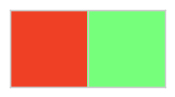

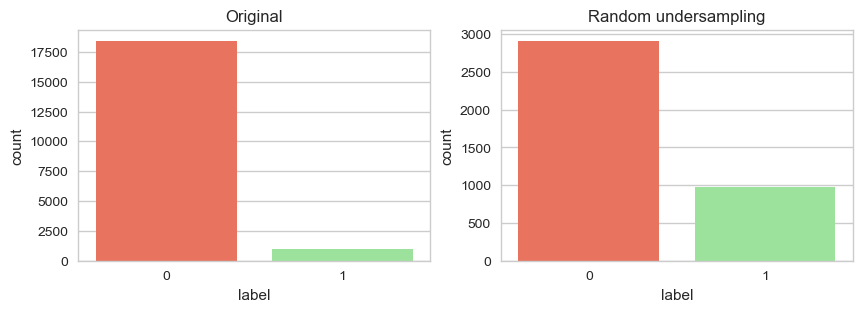

In [32]:
colors = ['tomato','lightgreen']
sns.palplot(sns.xkcd_palette(colors))

# Undersampling.
# Primero probamos reducir de forma aleatoria el set de datos con label 0
size = 0.15
np.random.seed(10) # usamos una semilla para que el resultado sea reproducible
d = pd.Index(np.random.choice(dftrain.loc[dftrain['label']==0]['person']
                                     , size=round(len(dftrain.index.values)*size), replace=False))
d = d.union(dftrain.loc[dftrain['label'] == 1]['person'])

d = pd.DataFrame({'person':d})
d = d.merge(dftrain, how='inner', on='person')
d = d.set_index('person')

plt.figure(figsize=(10,3))
plt.subplot(1,2,1)
sns.countplot('label',data=dftrain, palette=colors)
plt.title('Original')

plt.subplot(1,2,2)
sns.countplot('label',data=d, palette=colors)
plt.title('Random undersampling')
plt.show()

## Separamos los sets

In [33]:
X = d.drop('label',axis=1)
y = d.loc[:,'label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

print(X_train.shape)
print(X_test.shape)
X_train.head()

(2919, 33)
(973, 33)


,timestamp,event,url,sku,model,condition,storage,color,skus,search_term,...,month,weekday,skus_count,make,url_make,os,browser,color_split,last_tx,first_tx
person,,,,,,,,,,,,,,,,,,,,,
80439dfb,2018-04-20 13:20:04,viewed product,NaN,4381,iPad Mini 2 Wi-Fi + 4G,Excelente,16GB,Prateado,NaN,NaN,...,2018-04-01,Friday,NaN,iPad,NaN,NaN,NaN,Prateado,19899345.0,19899388.0
be490e92,2018-05-17 01:46:52,checkout,NaN,8541,Samsung Galaxy S7 Edge,Bom,32GB,Dourado,NaN,NaN,...,2018-05-01,Thursday,NaN,Samsung,NaN,NaN,NaN,Dourado,17608137.0,18935533.0
feeb5b65,2018-05-29 13:24:13,viewed product,NaN,10240,iPhone 7 Plus,Excelente,128GB,Dourado,NaN,NaN,...,2018-05-01,Tuesday,NaN,iPhone,NaN,NaN,NaN,Dourado,16529496.0,16861883.0
fb23398e,2018-05-26 15:38:11,generic listing,NaN,NaN,NaN,NaN,NaN,NaN,"2820,6706,2750,6720,6649,7252,7224,12604,6663,...",NaN,...,2018-05-01,Saturday,12.0,NaN,NaN,NaN,NaN,NaN,16780658.0,18003571.0
a583a0d8,2018-05-17 19:15:50,checkout,NaN,5005,Motorola Moto G3 4G,Excelente,16GB,Branco Pink,NaN,NaN,...,2018-05-01,Thursday,NaN,Motorola,NaN,NaN,NaN,Branco,17545199.0,17545432.0


In [35]:
X_train.head()

,timestamp,event,url,sku,model,condition,storage,color,skus,search_term,...,month,weekday,skus_count,make,url_make,os,browser,color_split,last_tx,first_tx
person,,,,,,,,,,,,,,,,,,,,,
80439dfb,2018-04-20 13:20:04,viewed product,NaN,4381,iPad Mini 2 Wi-Fi + 4G,Excelente,16GB,Prateado,NaN,NaN,...,2018-04-01,Friday,NaN,iPad,NaN,NaN,NaN,Prateado,19899345.0,19899388.0
be490e92,2018-05-17 01:46:52,checkout,NaN,8541,Samsung Galaxy S7 Edge,Bom,32GB,Dourado,NaN,NaN,...,2018-05-01,Thursday,NaN,Samsung,NaN,NaN,NaN,Dourado,17608137.0,18935533.0
feeb5b65,2018-05-29 13:24:13,viewed product,NaN,10240,iPhone 7 Plus,Excelente,128GB,Dourado,NaN,NaN,...,2018-05-01,Tuesday,NaN,iPhone,NaN,NaN,NaN,Dourado,16529496.0,16861883.0
fb23398e,2018-05-26 15:38:11,generic listing,NaN,NaN,NaN,NaN,NaN,NaN,"2820,6706,2750,6720,6649,7252,7224,12604,6663,...",NaN,...,2018-05-01,Saturday,12.0,NaN,NaN,NaN,NaN,NaN,16780658.0,18003571.0
a583a0d8,2018-05-17 19:15:50,checkout,NaN,5005,Motorola Moto G3 4G,Excelente,16GB,Branco Pink,NaN,NaN,...,2018-05-01,Thursday,NaN,Motorola,NaN,NaN,NaN,Branco,17545199.0,17545432.0


### Aplicamos mean encoding

In [38]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold

In [39]:
features = ['event', 'sku', 'model', 'condition',
       'storage', 'color', 'skus', 'search_term', 'staticpage',
       'campaign_source', 'search_engine', 'channel', 'new_vs_returning',
       'city', 'region', 'country', 'device_type', 'screen_resolution',
       'operating_system_version', 'browser_version', 'day', 'month',
       'weekday', 'make', 'url_make', 'os', 'browser',
       'color_split']

### CV Loop

In [40]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=123)

In [41]:
train_new = X_train.copy()
train_new['label'] = y_train
columns = train_new.columns.values.tolist()

for feat in features:
    columns.append(feat + '_mean_target')
X_train_mean_enc = pd.DataFrame(columns=columns)

for tr_ind, val_ind in skf.split(train_new, y_train):
    X_tr, X_val = train_new.iloc[tr_ind], train_new.iloc[val_ind]
    print(len(tr_ind), len(val_ind))
#     print(X_tr.columns)
    for col in features:
#         print(col)
        means = X_val[col].map(X_tr.groupby(col)['label'].mean())
#         X_tr[col + '_mean_target'] = X_tr[col].map(X_tr.groupby(col)['label'].mean())
        X_val[col + '_mean_target'] = means
    
    X_train_mean_enc = X_train_mean_enc.append(X_val)

prior = train_new['label'].mean()
X_train_mean_enc.fillna(prior, inplace=True)

for col in X_train_mean_enc.columns[-28:]:
    # Print correlation
    encoded_feature = X_train_mean_enc[col].values
    print(col, np.corrcoef(X_train_mean_enc['label'].values, encoded_feature)[0][1])


2334 585


C:\Users\vfarfan\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


2335 584
2335 584
2336 583
2336 583
event_mean_target 0.231191646259
sku_mean_target 0.0111900366407
model_mean_target 0.00331559294922
condition_mean_target 0.0696322552592
storage_mean_target 0.0310458502248
color_mean_target 0.0712756667307
skus_mean_target 0.0213805158429
search_term_mean_target -0.0344230359959
staticpage_mean_target -0.0141707580112
campaign_source_mean_target 0.0199175838575
search_engine_mean_target 0.0235373979686
channel_mean_target -0.0320602646263
new_vs_returning_mean_target 0.0183584730391
city_mean_target 0.0130382490633
region_mean_target -0.0162927314754
country_mean_target 0.00450142735947
device_type_mean_target -0.0219903107096
screen_resolution_mean_target 0.0378821738301
operating_system_version_mean_target 0.00250124346343
browser_version_mean_target 0.0278429050735
day_mean_target 0.234683621973
month_mean_target 0.232673424148
weekday_mean_target 0.0239736151832
make_mean_target 0.0143700281818
url_make_mean_target -0.0142643390225
os_mean_targ

### Expanding mean encoding

In [42]:
# Expanding mean encoding
# train_new = last_tx
# features={'event'}
for col in features:
    cumsum = X_train_mean_enc.groupby(col)['label'].cumsum() - X_train_mean_enc['label']
    cumcnt = X_train_mean_enc.groupby(col).cumcount()
    X_train_mean_enc[col + '_mean_exp'] = cumsum/cumcnt
    X_train_mean_enc[col + '_mean_exp'] = X_train_mean_enc[col + '_mean_exp'].replace(np.inf, np.nan)
    X_train_mean_enc[col + '_mean_exp'] = X_train_mean_enc[col + '_mean_exp'].fillna(0)
#     print(train_new[col], train_new[col + '_mean_target'])
    
    
    # Print correlation
    encoded_feature = X_train_mean_enc[col + '_mean_exp'].values
#     print(encoded_feature)
    print(col, np.corrcoef(X_train_mean_enc['label'].values, encoded_feature)[0][1])

event 0.196845383277
sku 0.0132697301098
model 0.0161226730589
condition 0.0578361946972
storage 0.0524678384798
color 0.055316421279
skus -0.0471604154019
search_term -0.0592707116111
staticpage -0.00786226667035
campaign_source -0.0047124797567
search_engine 0.00943186160945
channel -0.0435408829747
new_vs_returning -0.00638408935991
city 0.004202102169
region -0.0442342622485
country -0.0130801690539
device_type -0.0286109583295
screen_resolution 0.0161918238837
operating_system_version 0.0059876295547
browser_version -0.017559066448
day 0.155567731735
month 0.213507192308
weekday 0.0344378776618
make 0.0519840875422
url_make -0.00914245818552
os 0.0212245927126
browser -0.00677927150939
color_split 0.0512516827693


In [43]:
X_train_mean_enc.columns

Index(['timestamp', 'event', 'url', 'sku', 'model', 'condition', 'storage',
       'color', 'skus', 'search_term', 'staticpage', 'campaign_source',
       'search_engine', 'channel', 'new_vs_returning', 'city', 'region',
       'country', 'device_type', 'screen_resolution',
       'operating_system_version', 'browser_version', 'day', 'month',
       'weekday', 'skus_count', 'make', 'url_make', 'os', 'browser',
       'color_split', 'last_tx', 'first_tx', 'label', 'event_mean_target',
       'sku_mean_target', 'model_mean_target', 'condition_mean_target',
       'storage_mean_target', 'color_mean_target', 'skus_mean_target',
       'search_term_mean_target', 'staticpage_mean_target',
       'campaign_source_mean_target', 'search_engine_mean_target',
       'channel_mean_target', 'new_vs_returning_mean_target',
       'city_mean_target', 'region_mean_target', 'country_mean_target',
       'device_type_mean_target', 'screen_resolution_mean_target',
       'operating_system_version_mean_ta

### Aplicamos encoding al set de testeo

In [44]:
# X_train_mean_enc = train_new
X_test_mean_enc = X_test
for feat in features:
    means = X_test[feat].map(X_train_mean_enc.groupby(feat)[feat + '_mean_exp'].mean())
    X_test_mean_enc[feat + '_mean_exp'] = means
    X_test_mean_enc[feat + '_mean_exp'].fillna(prior, inplace=True)

C:\Users\vfarfan\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
C:\Users\vfarfan\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\generic.py:3660: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


In [45]:
# X_train_mean_enc = train_new
X_test_mean_enc = X_test
for feat in features:
#     means = X_test[feat].map(X_train_mean_enc.groupby(feat)['label'].mean())
    means = X_test[feat].map(X_train_mean_enc.groupby(feat)[feat + '_mean_target'].mean())
    X_test_mean_enc[feat + '_mean_target'] = means
    X_test_mean_enc[feat + '_mean_target'].fillna(prior, inplace=True)


C:\Users\vfarfan\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\vfarfan\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\generic.py:3660: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


In [46]:
X_train_mean_enc.head()

,timestamp,event,url,sku,model,condition,storage,color,skus,search_term,...,operating_system_version_mean_exp,browser_version_mean_exp,day_mean_exp,month_mean_exp,weekday_mean_exp,make_mean_exp,url_make_mean_exp,os_mean_exp,browser_mean_exp,color_split_mean_exp
ff75820c,2018-05-19 22:15:50,viewed product,0.254539,6901,iPhone 6S,Excelente,64GB,Dourado,0.254539,0.254539,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
bf8d62a1,2018-05-28 02:37:15,viewed product,0.254539,12772,Samsung Galaxy S8 Plus,Bom,64GB,Preto,0.254539,0.254539,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7e268fde,2018-05-23 13:48:41,viewed product,0.254539,7377,Samsung Galaxy J3,Excelente,8GB,Branco,0.254539,0.254539,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
d9c78c17,2018-05-28 19:56:47,viewed product,0.254539,10126,iPhone 7 Plus,Bom,256GB,Preto Brilhante,0.254539,0.254539,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
58c76b78,2018-05-23 18:39:20,checkout,0.254539,6023,iPhone 5s,Bom - Sem Touch ID,16GB,Dourado,0.254539,0.254539,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


###  Nos quedamos con las features para el modelo

In [47]:
training_features = ['event_mean_exp', 'sku_mean_exp', 'model_mean_exp',
       'condition_mean_exp', 'storage_mean_exp', 'color_mean_exp',
       'skus_mean_exp', 'search_term_mean_exp', 'staticpage_mean_exp',
       'campaign_source_mean_exp', 'search_engine_mean_exp',
       'channel_mean_exp', 'new_vs_returning_mean_exp', 'city_mean_exp',
       'region_mean_exp', 'country_mean_exp', 'device_type_mean_exp',
       'screen_resolution_mean_exp', 'operating_system_version_mean_exp',
       'browser_version_mean_exp', 'day_mean_exp', 'month_mean_exp',
       'weekday_mean_exp', 'make_mean_exp', 'url_make_mean_exp', 'os_mean_exp',
       'browser_mean_exp', 'color_split_mean_exp','event_mean_target', 'sku_mean_target',
       'model_mean_target', 'condition_mean_target', 'storage_mean_target',
       'color_mean_target', 'skus_mean_target', 'search_term_mean_target',
       'staticpage_mean_target', 'campaign_source_mean_target',
       'search_engine_mean_target', 'channel_mean_target',
       'new_vs_returning_mean_target', 'city_mean_target',
       'region_mean_target', 'country_mean_target', 'device_type_mean_target',
       'screen_resolution_mean_target', 'operating_system_version_mean_target',
       'browser_version_mean_target', 'day_mean_target', 'month_mean_target',
       'weekday_mean_target', 'make_mean_target', 'url_make_mean_target',
       'os_mean_target', 'browser_mean_target', 'color_split_mean_target']

y_train = X_train_mean_enc['label']
X_train_feat = X_train_mean_enc[training_features]
X_test_feat = X_test_mean_enc[training_features]

# Creamos el dataset final con los datos de la última transacción y de cada sesión por persona

In [48]:
X_train_feat = X_train_feat.merge(user_session.set_index('person'), how='inner', left_index=True, right_index=True)
X_train_feat = X_train_feat.merge(pd.DataFrame(last_tx.set_index('person').loc[:,('last_tx','first_tx')]), how='inner', left_index=True, right_index=True)
X_train_feat = X_train_feat.merge(dfcontent.set_index('person'), how='inner', left_index=True, right_index=True)

X_test_feat = X_test_feat.merge(user_session.set_index('person'), how='inner', left_index=True, right_index=True)
X_test_feat = X_test_feat.merge(pd.DataFrame(last_tx.set_index('person').loc[:,('last_tx','first_tx')]), how='inner', left_index=True, right_index=True)
X_test_feat = X_test_feat.merge(dfcontent.set_index('person'), how='inner', left_index=True, right_index=True)
X_test_feat.head()

,event_mean_exp,sku_mean_exp,model_mean_exp,condition_mean_exp,storage_mean_exp,color_mean_exp,skus_mean_exp,search_term_mean_exp,staticpage_mean_exp,campaign_source_mean_exp,...,512MB_conversion,64GB_conversion,8GB_conversion,Branco_conversion,Cinza_conversion,Dourado_conversion,Ouro_conversion,Prateado_conversion,Preto_conversion,color_other_conversion
person,,,,,,,,,,,,,,,,,,,,,
5cc1dc20,0.282387,0.106245,0.239709,0.221458,0.232895,0.228930,0.254539,0.254539,0.254539,0.254539,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ffaf0844,0.299738,0.254539,0.254539,0.254539,0.254539,0.254539,0.254539,0.254539,0.254539,0.254539,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
a7fec2ea,0.282387,0.254539,0.111551,0.229095,0.195591,0.174012,0.254539,0.254539,0.254539,0.254539,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
69de5c37,0.282387,0.000000,0.221260,0.221458,0.232895,0.271528,0.254539,0.254539,0.254539,0.254539,...,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN
36f86988,0.282387,0.478307,0.425466,0.221458,0.176632,0.271528,0.254539,0.254539,0.254539,0.254539,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [49]:
X_test_feat = X_test_feat.fillna(0)
X_train_feat = X_train_feat.fillna(0)

In [50]:
X_test_feat.iloc[:,90:251].columns

Index(['Organic', 'Paid', 'Referral', 'Social', 'Unknown_x', 'Computer',
       'Smartphone', 'Tablet', 'Unknown_y', 'Android', 'Windows', 'iOS',
       'os_other', 'Asus', 'LG', 'Lenovo', 'Motorola', 'Quantum', 'Samsung',
       'Sony', 'iPad', 'iPhone', 'Bom', 'Bom - Sem Touch ID', 'Excelente',
       'Muito Bom', 'Novo', '128GB', '16GB', '256GB', '32GB', '4GB', '512MB',
       '64GB', '8GB', 'Branco', 'Cinza', 'Dourado', 'Ouro', 'Prateado',
       'Preto', 'color_other', 'Asus_checkout', 'LG_checkout',
       'Lenovo_checkout', 'Motorola_checkout', 'Quantum_checkout',
       'Samsung_checkout', 'Sony_checkout', 'iPad_checkout', 'iPhone_checkout',
       'Bom_checkout', 'Bom - Sem Touch ID_checkout', 'Excelente_checkout',
       'Muito Bom_checkout', 'Novo_checkout', '128GB_checkout',
       '16GB_checkout', '256GB_checkout', '32GB_checkout', '4GB_checkout',
       '512MB_checkout', '64GB_checkout', '8GB_checkout', 'Branco_checkout',
       'Cinza_checkout', 'Dourado_checkout', 'Ouro

In [51]:
### Funciones para entrenamiento y evaluación de modelos
def evaluate_model(y, pred, pred_prob):
    # Making the Confusion Matrix
    cm = confusion_matrix(y, pred)
    fig= plt.figure(figsize=(4,2))# to plot the graph
    sns.heatmap(cm,cmap="coolwarm_r",annot=True,linewidths=0.5, fmt='g')
    plt.title("Confusion_matrix")
    plt.xlabel("Predicted_class")
    plt.ylabel("Real class")
    plt.show()

    # Evaluamos el modelo
    logit_roc_auc = roc_auc_score(y, pred)
    fpr, tpr, thresholds = metrics.roc_curve(y, pred, pos_label=1)
    plt.figure(figsize=(10,3))
    plt.subplot(1, 2, 1)
    plt.plot(fpr, tpr, label='AUC (area = %0.5f)' % logit_roc_auc)
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.savefig('Log_ROC')
    # plt.show()

    # Evaluamos el modelo
    logit_roc_auc = roc_auc_score(y, pred_prob)
    fpr, tpr, thresholds = metrics.roc_curve(y, pred_prob, pos_label=1)
    plt.subplot(1, 2, 2)
    # plt.figure()
    plt.plot(fpr, tpr, label='AUC (area = %0.5f)' % logit_roc_auc)
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.savefig('Log_ROC')
    plt.tight_layout()
    plt.show()

#     accuracy = metrics.accuracy_score(y, pred)
#     print("Accuracy: %.2f%%" % (accuracy * 100.0))
    
    return logit_roc_auc


    
def train_model(model, X_train, y_train, feat=False):
    #Fit the algorithm on the data
    model.fit(X_train, y_train)
        
    #Predict training set
    train_pred = model.predict(X_train)
    train_predp = model.predict_proba(X_train)[:,1]
    
    # CV
    cv_score = cross_val_score(model, X_train, y_train, cv=5, scoring='roc_auc')
    print ("CV Score : Mean - %.7g | Std - %.7g | Min - %.7g | Max - %.7g" % (np.mean(cv_score),np.std(cv_score)
                                                                          ,np.min(cv_score),np.max(cv_score)))
    
#     # Evaluate model on training set
#     evaluate_model(y_train, train_pred, train_predp)
    
    if feat:
        # Feature importance
        feat_imp = pd.Series(model.feature_importances_, X_train.columns).sort_values(ascending=False)
        plt.figure(figsize=(10,2))
        feat_imp.plot(kind='bar', title='Feature Importances')
        plt.ylabel('Feature Importance Score')  

# Seleccionamos las variables para el modelo

In [52]:
model_features = [#'skus_count', 
#                   'session_count',
                  'avg_events_per_session',
#                   'total_time',
                  'avg_session_time',
#                   'skus_count_sum',
#                   'skus_count_mean',
                  'ad campaign hit',
                  'brand listing',
                  'checkout',
                  'conversion',
                  'generic listing',
                  'lead',
                  'search engine hit',
                  'searched products',
                  'staticpage',
                  'viewed product',
                  'visited site',
                  'conversion_rate',
                  'checkout_conversion_rate',
##### last transaction data
    'event_mean_exp',
#     'sku_mean_exp',
#     'model_mean_exp',
    'condition_mean_exp',
    'storage_mean_exp',
#     'color_mean_exp',
       'skus_mean_exp',
    'search_term_mean_exp',
    'staticpage_mean_exp',
       'campaign_source_mean_exp',
    'search_engine_mean_exp',
       'channel_mean_exp', 
    'new_vs_returning_mean_exp',
    'city_mean_exp',
       'region_mean_exp',
    'country_mean_exp',
    'device_type_mean_exp',
       'screen_resolution_mean_exp',
    'operating_system_version_mean_exp',
    'browser_version_mean_exp',
    'day_mean_exp',
    'month_mean_exp',
    'weekday_mean_exp',
    'make_mean_exp',
    'url_make_mean_exp',
    'os_mean_exp',
    'browser_mean_exp',
    'color_split_mean_exp',
    'last_tx',
    'first_tx',
    
    'criteo', 'emblue', 'google',
        'campaign_other', 
    
    'rtbhouse', 'zanox',
     'lg', 'motorola', 'samsung',
       'sony'
     , 'url_other',
    
    'Direct', 'Email', 'Organic', 'Paid', 'Referral', 'Social', 'Unknown_x'
    , 'Computer', 'Smartphone', 'Tablet',
       'Unknown_y', 
                 ]

In [53]:
X_train = X_train_feat[model_features]
X_test = X_test_feat[model_features]

## 4.XGBoost


In [54]:
from numpy import loadtxt
import xgboost as xgb
from xgboost import XGBClassifier

In [55]:
from imblearn.over_sampling import SMOTE

print("Before OverSampling, counts of label '1': {}".format(sum(y_train==1)))
print("Before OverSampling, counts of label '0': {} \n".format(sum(y_train==0)))

sm = SMOTE(random_state=2, k_neighbors=5)
X_train_res, y_train_res = sm.fit_sample(X_train, y_train.ravel())

print("After OverSampling, counts of label '1': {}".format(sum(y_train_res==1)))
print("After OverSampling, counts of label '0': {}".format(sum(y_train_res==0)))

X_train_res = pd.DataFrame(X_train_res, columns=X_train.columns)

Before OverSampling, counts of label '1': 743
Before OverSampling, counts of label '0': 2176 

After OverSampling, counts of label '1': 2176
After OverSampling, counts of label '0': 2176


CV Score : Mean - 0.8302901 | Std - 0.1560823 | Min - 0.6061831 | Max - 0.9707385


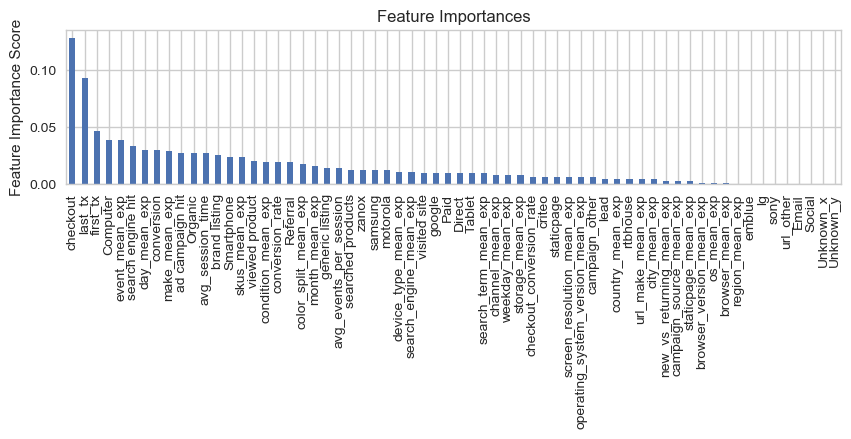

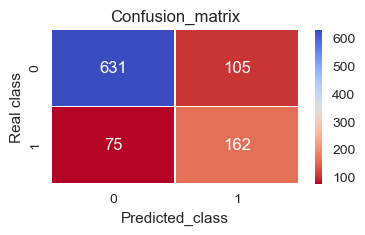

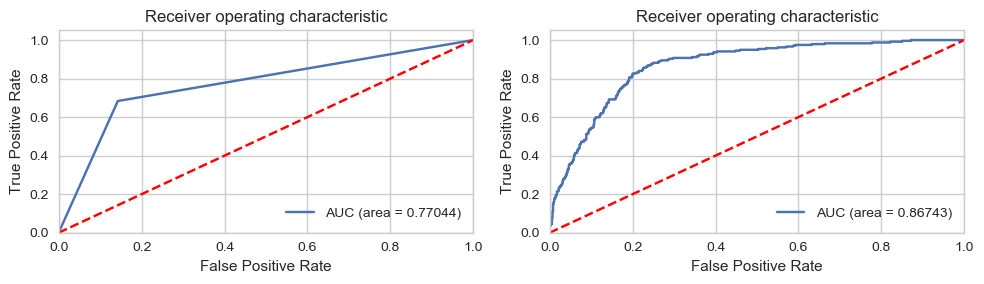

0.86742971473124197

In [56]:
XGB_classifier = XGBClassifier()

train_model(XGB_classifier, X_train_res, y_train_res, feat=True)

y_pred = XGB_classifier.predict(X_test)
y_predp = XGB_classifier.predict_proba(X_test)[:,1]


evaluate_model(y_test, y_pred, y_predp)

# Predicción sobre set de testo de Kaggle

In [57]:
dftest = pd.read_csv("data/trocafone_kaggle_test.csv")
dftest = dftest.set_index('person')
# Hacemos un merge para agregar los datos anteriores a los usuarios del set de testeo
dftest = last_tx.set_index('person').merge(dftest, how='inner',left_index=True,right_index=True)

print('Cantidad de personas:',dftest.shape[0])
dftest.head()

Cantidad de personas: 19415


,timestamp,event,url,sku,model,condition,storage,color,skus,search_term,...,month,weekday,skus_count,make,url_make,os,browser,color_split,last_tx,first_tx
person,,,,,,,,,,,,,,,,,,,,,
00091926,2018-05-31 19:52:03,brand listing,NaN,NaN,NaN,NaN,NaN,NaN,"2751,101,2709,2712,2708",NaN,...,2018-05-01,Thursday,5.0,NaN,NaN,NaN,NaN,NaN,16333426.0,18744440.0
00091a7a,2018-03-26 14:56:58,brand listing,NaN,NaN,NaN,NaN,NaN,NaN,"10323,3659,87,10308,10085,10113,276,8261,81,99...",NaN,...,2018-03-01,Monday,12.0,NaN,NaN,NaN,NaN,NaN,22053531.0,22053878.0
000ba417,2018-05-26 13:09:22,conversion,NaN,7631,Motorola Moto G3 4G,Bom,16GB,Preto,NaN,NaN,...,2018-05-01,Saturday,NaN,Motorola,NaN,NaN,NaN,Preto,16789587.0,17574244.0
000e4d9e,2018-05-30 17:45:22,viewed product,NaN,3360,Samsung Galaxy S6 Flat,Muito Bom,32GB,Preto,NaN,NaN,...,2018-05-01,Wednesday,NaN,Samsung,NaN,NaN,NaN,Preto,16427427.0,17658054.0
000e619d,2018-05-18 16:25:38,viewed product,NaN,8261,iPhone SE,Bom,64GB,Ouro Rosa,NaN,NaN,...,2018-05-01,Friday,NaN,iPhone,NaN,NaN,NaN,Ouro,17469011.0,17721341.0


## Aplicamos encoding

In [58]:
dftest_mean_enc = dftest
for feat in features:
    means = dftest[feat].map(X_train_mean_enc.groupby(feat)[feat + '_mean_exp'].mean())
    dftest_mean_enc[feat + '_mean_exp'] = means
    dftest_mean_enc[feat + '_mean_exp'].fillna(prior, inplace=True)

In [59]:
for feat in features:
#     means = X_test[feat].map(X_train_mean_enc.groupby(feat)['label'].mean())
    means = dftest[feat].map(X_train_mean_enc.groupby(feat)[feat + '_mean_target'].mean())
    dftest_mean_enc[feat + '_mean_target'] = means
    dftest_mean_enc[feat + '_mean_target'].fillna(prior, inplace=True)


In [60]:
training_features = ['event_mean_exp', 'sku_mean_exp', 'model_mean_exp',
       'condition_mean_exp', 'storage_mean_exp', 'color_mean_exp',
       'skus_mean_exp', 'search_term_mean_exp', 'staticpage_mean_exp',
       'campaign_source_mean_exp', 'search_engine_mean_exp',
       'channel_mean_exp', 'new_vs_returning_mean_exp', 'city_mean_exp',
       'region_mean_exp', 'country_mean_exp', 'device_type_mean_exp',
       'screen_resolution_mean_exp', 'operating_system_version_mean_exp',
       'browser_version_mean_exp', 'day_mean_exp', 'month_mean_exp',
       'weekday_mean_exp', 'make_mean_exp', 'url_make_mean_exp', 'os_mean_exp',
       'browser_mean_exp', 'color_split_mean_exp','event_mean_target', 'sku_mean_target',
       'model_mean_target', 'condition_mean_target', 'storage_mean_target',
       'color_mean_target', 'skus_mean_target', 'search_term_mean_target',
       'staticpage_mean_target', 'campaign_source_mean_target',
       'search_engine_mean_target', 'channel_mean_target',
       'new_vs_returning_mean_target', 'city_mean_target',
       'region_mean_target', 'country_mean_target', 'device_type_mean_target',
       'screen_resolution_mean_target', 'operating_system_version_mean_target',
       'browser_version_mean_target', 'day_mean_target', 'month_mean_target',
       'weekday_mean_target', 'make_mean_target', 'url_make_mean_target',
       'os_mean_target', 'browser_mean_target', 'color_split_mean_target']

dftest_feat = dftest_mean_enc[training_features]

## Agregamos otros datos

In [61]:
dftest_feat = dftest_feat.merge(user_session.set_index('person'), how='inner', left_index=True, right_index=True)
dftest_feat = dftest_feat.merge(pd.DataFrame(last_tx.set_index('person').loc[:,('last_tx','first_tx')]), how='inner', left_index=True, right_index=True)
dftest_feat = dftest_feat.merge(dfcontent.set_index('person'), how='inner', left_index=True, right_index=True)
dftest_feat.head()


,event_mean_exp,sku_mean_exp,model_mean_exp,condition_mean_exp,storage_mean_exp,color_mean_exp,skus_mean_exp,search_term_mean_exp,staticpage_mean_exp,campaign_source_mean_exp,...,512MB_conversion,64GB_conversion,8GB_conversion,Branco_conversion,Cinza_conversion,Dourado_conversion,Ouro_conversion,Prateado_conversion,Preto_conversion,color_other_conversion
person,,,,,,,,,,,,,,,,,,,,,
00091926,0.400059,0.254539,0.254539,0.254539,0.254539,0.254539,0.254539,0.254539,0.254539,0.254539,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
00091a7a,0.400059,0.254539,0.254539,0.254539,0.254539,0.254539,0.254539,0.254539,0.254539,0.254539,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
000ba417,0.345353,0.254539,0.541138,0.221458,0.256190,0.271528,0.254539,0.254539,0.254539,0.254539,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN
000e4d9e,0.282387,0.000000,0.153953,0.238760,0.232895,0.271528,0.254539,0.254539,0.254539,0.254539,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
000e619d,0.282387,0.083333,0.210322,0.221458,0.176632,0.174012,0.254539,0.254539,0.254539,0.254539,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [62]:
dftest_feat = dftest_feat.fillna(0)
dftest_feat = dftest_feat[model_features]

##  XGBoost

(19415, 1)


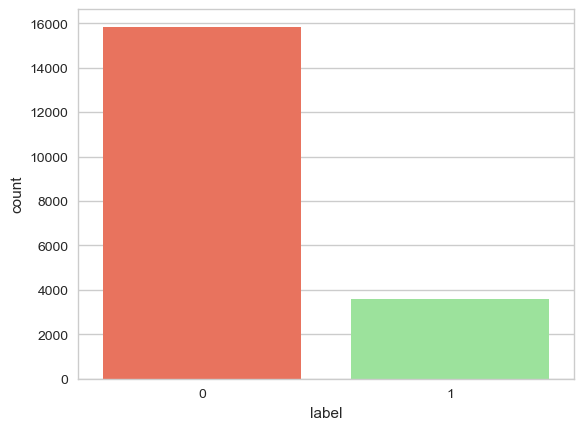

0    15842
1     3573
Name: label, dtype: int64


array([ 0.41365311,  0.72708511,  0.44067934, ...,  0.41710186,
        0.48469821,  0.04007628], dtype=float32)

In [63]:
# Predicción de los labels 0 o 1
predictions = XGB_classifier.predict(dftest_feat)
dfsub = pd.DataFrame(predictions, columns=['label'], index=dftest_feat.index)
print(dfsub.shape)

sns.countplot('label',data=dfsub, palette=colors)
plt.show()

print(dfsub['label'].value_counts())

# Predicción de la probabilidad de conversión
predictions = XGB_classifier.predict_proba(dftest_feat)
dfsub = pd.DataFrame(predictions[:,1], columns=['label'], index=dftest_feat.index)

predictions[:,1]

In [64]:
dfsub.to_csv('20181206_XGB.csv', sep=',', header=True)